## Boosting Model for CT adjustment

### Imports & Utils

In [ ]:
from io import BytesIO, StringIO
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_poisson_deviance
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance, DMatrix
from lightgbm import LGBMRegressor, plot_importance
from sklearn.tree import DecisionTreeClassifier

# parameter tuning
from itertools import product
from collections import OrderedDict, defaultdict
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
# for XGBoost parameter tuning
XGB_space= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.01)),
    'max_depth': hp.quniform("max_depth", 5, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 500, 2000, 100),
    'min_child_weight': 1.12, #not much impact
    'colsample_bytree': 0.62, #not much impact
    'colsample_bylevel': 0.7, #not much impact
    'objective':'reg:squarederror',
    'reg_lambda': hp.uniform('reg_lambda', 0.1, 1.0),
    'reg_alpha' : hp.quniform('reg_alpha', 5, 20, 1),
}


def XGB_hyperparameter_tuning(space):
    model = XGBRegressor(learning_rate = space['learning_rate'],
                         n_estimators = int(space['n_estimators']), 
                         max_depth = int(space['max_depth']), 
                         min_child_weight = space['min_child_weight'],
                         colsample_bytree = space['colsample_bytree'],
                         colsample_bylevel = space['colsample_bylevel'],
                         objective = space['objective'],
                        #  eval_metric = space['eval_metric'],
                         reg_lambda = space['reg_lambda'],
                         reg_alpha = int(space['reg_alpha']), 
                         )
    
    evaluation = [(X_train_normalized, y_train), (X_test_normalized, y_test)]
    
    model.fit(X_train_normalized, y_train, eval_set=evaluation, eval_metric="mae", early_stopping_rounds=3, verbose=False)

    pred = model.predict(X_test_normalized)
    error= mean_absolute_error(y_test, pred)
    # print("SCORE:", error)

    return {'loss':error, 'status': STATUS_OK, 'model': model}



In [ ]:
# for LightGBM parameter tuning
LGBM_space= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.01)),
    'num_leaves': hp.quniform('num_leaves', 50, 500, 2), #replace max_depth in XGB with num_leaves in LGBM
    'n_estimators': hp.quniform('n_estimators', 500, 2000, 100),
    'min_child_weight': 1.12, #not much impact
    'colsample_bytree': 0.62, #not much impact
    'colsample_bylevel': 0.7, #not much impact
    'objective':'regression', 
    'reg_lambda': hp.uniform('reg_lambda', 0.1, 1.0),
    'reg_alpha' : hp.quniform('reg_alpha', 5, 20, 1),
}


def LGBM_hyperparameter_tuning(space):
    model =LGBMRegressor(learning_rate = space['learning_rate'],
                         n_estimators = int(space['n_estimators']), 
                         num_leaves = int(space['num_leaves']), 
                         min_child_weight = space['min_child_weight'],
                         colsample_bytree = space['colsample_bytree'],
                         colsample_bylevel = space['colsample_bylevel'],
                         objective = space['objective'],
                        #  eval_metric = space['eval_metric'],
                         reg_lambda = space['reg_lambda'],
                         reg_alpha = int(space['reg_alpha']), 
                         )
    
    evaluation = [(X_train_normalized, y_train), (X_test_normalized, y_test)]
    
    model.fit(X_train_normalized, y_train, eval_set=evaluation, eval_metric="mae", early_stopping_rounds=3, verbose=False)

    pred = model.predict(X_test_normalized)
    error= mean_absolute_error(y_test, pred)
    # print("SCORE:", error)

    return {'loss':error, 'status': STATUS_OK, 'model': model}


### Load Data

In [ ]:
url='https://drive.google.com/file/d/1K9DgN4kznwJOimZD6i3iUfVn2icfdFBX/view?usp=sharing'
file_id = url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
df = pd.read_csv(dwn_url)
df.head()

,ct_key,median_rental_price,average_annual_rent_as_percentage_of_property_value,farm_score,pop_density,densely_urban_score,urban_score,suburban_score,rural_score,remote_score,built 1995 or later,built 1970-1994,built 1940-1969,built before 1940,single_family_detached_pct,rowhouses_and_attached_homes_pct,small_apt_buildings_pct,complexes/high_rise_apt_pct,mobile_home_pct,0_bedroom_pct,1_bedroom_pct,2_bedroom_pct,3_bedroom_pct,4_bedroom_pct,5_bedroom_pct,homeownership_rate,rental_rate,seasonal_housing_pct,vacant_homes_pct,family_friendly_score,first_time_homebuyer_score,luxury_communities_score,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,commute_under_15_min_pct,commute_15-30_min_pct,commute_30-45_min_pct,commute_45-60_min_pct,commute_over_60_min_pct,...,linear_pop_trend_since_2014,avg_annual_pop_change_since_2014,annual_births_per_resident,workforce_fraction,car,carpool,public_transportation,walk,WFH,other_mode_of_transit,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,family_households_fraction,nonfamily_households_fraction,STEM_jobs,education&health_care,total_households,avg_family_size,avg_nonfamily_size,avg_household_size,<200k,200-300k,300-400k,400-500k,500-750k,750-1000k,>1M,married,divorced/separated/widowed,never_married,percent_mortgage,median_mortgage_value,vacancy_rate,built 2014 or later,built 2010-2013,built 2000-2009
0,8001007801,1316.0,6.024884,100.0,15066.473217,7.0,10.0,33.0,83.0,93.0,13.033873,45.729013,36.745214,4.491900,19.072165,4.639175,12.812960,63.475700,0.000000,10.824742,42.341679,32.621502,6.701031,6.185567,1.325479,8.234096,91.765904,0.000000,5.743741,88.003519,88.709612,93.683181,99.866645,53.691517,88.873766,11.347926,49.596774,17.914747,21.140553,0.000000,...,0.011039,0.001638,0.014503,0.423012,0.445714,0.258286,0.204571,0.029714,0.020000,0.041714,32744,40921,19534,42004,49152,30554,0.595313,0.404687,17.2,8.7,1280,4.37,1.29,3.18,0.429907,0.429907,0.000000,0.000000,0.084112,0.0,0.056075,33.7,22.8,43.5,0.803738,173000.0,0.057437,0.000000,0.000000,0.130339
1,8001007802,1239.0,9.187587,100.0,15270.696288,7.0,10.0,33.0,83.0,93.0,1.555412,53.856124,43.097861,1.490603,15.942968,3.370058,3.434867,76.085548,1.166559,3.240441,46.143876,37.070642,8.101102,5.443940,0.000000,8.741817,91.258183,0.000000,6.351264,94.606671,88.951501,96.101273,99.907889,52.739850,91.316781,9.666506,45.915901,23.006283,17.738038,3.673272,...,0.024965,0.024260,0.012650,0.447256,0.543145,0.233461,0.160594,0.012464,0.009108,0.041227,30598,31685,26144,41771,41349,39394,0.660900,0.339100,16.6,6.1,1445,3.83,1.74,3.21,0.478632,0.521368,0.000000,0.000000,0.000000,0.0,0.000000,34.1,16.1,49.8,0.724409,256600.0,0.063513,0.000000,0.000000,0.015554
2,8001007900,1482.0,10.041348,100.0,8644.378631,14.0,6.0,26.0,76.0,86.0,2.570440,39.001483,49.085517,9.342561,51.754820,3.311913,5.635195,39.298072,0.000000,4.201681,18.388532,37.716263,25.259516,12.357884,2.076125,34.526095,65.473905,0.000000,5.882353,82.335231,46.875042,81.712204,96.969947,50.823170,61.079491,11.917467,46.567058,22.198506,16.435432,2.881537,...,-0.029572,-0.030480,0.006510,0.501407,0.675439,0.168421,0.090175,0.029825,0.016140,0.020000,41738,47163,30506,48359,53658,38016,0.576155,0.423845,10.2,13.7,1904,3.92,1.59,2.98,0.595016,0.213396,0.176012,0.000000,0.000000,0.0,0.015576,38.7,14.9,46.5,0.860395,174000.0,0.058824,0.002966,0.014829,0.007909
3,8001008000,1499.0,7.532211,100.0,7448.779496,17.0,3.0,23.0,73.0,83.0,0.767123,23.342466,73.643836,2.246575,73.534247,5.424658,9.972603,11.013699,0.054795,0.054795,12.931507,21.972603,29.972603,23.178082,11.890411,51.528767,48.471233,0.000000,2.794521,66.152493,27.052337,79.212530,90.990954,58.412211,74.119442,11.238025,36.440678,18.865144,23.139278,10.316875,...,0.010184,0.015024,0.016664,0.444160,0.733766,0.152597,0.078283,0.005411,0.021284,0.008658,50483,52450,30114,60798,67342,41587,0.688275,0.311725,17.8,14.2,1

In [ ]:
url = 'https://drive.google.com/file/d/19_JeXh3Ost8q7XyX-ZmnDPLCLKy7HC00/view?usp=sharing'
file_id = url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
listings = pd.read_csv(dwn_url)
listings.head()

,property_id,zipcode,latitude,longitude,list_date,sale_date,withdrawn_date,expired_date,cancelled_date,current_status,sale_price,geometry,index_right,ct_key
0,139863800,80112,39.58203,-104.92111,2016-03-01,2016-03-01,NaN,NaN,NaN,Sale,475000.0,POINT (-104.92111 39.58203),10690.0,8.005007e+09
1,139817027,80112,39.56911,-104.80082,2016-03-01,2016-04-08,NaN,NaN,NaN,Sale,295000.0,POINT (-104.80082 39.56911),10769.0,8.005007e+09
2,482086548,80138,39.49819,-104.73505,2016-03-01,2016-05-19,NaN,NaN,NaN,Sale,412000.0,POINT (-104.73505 39.49819),10115.0,8.035014e+09
3,494122461,80211,39.75414,-105.03118,2016-03-01,NaN,NaN,2016-03-01,NaN,Expired,NaN,POINT (-105.03118 39.75414),10477.0,8.031001e+09
4,523793691,80516,40.09353,-104.99471,2016-03-01,2016-04-15,NaN,NaN,NaN,Sale,398000.0,POINT (-104.99471 40.09353),10342.0,8.123002e+09


### Preprocess data 
- Parsing date time object 
- Merging CT-level features and listing datasets together
- Calculate listing and sales ratio
- Drop census tract with not enough data (less than 10 monthly data for listings/sales rate)
- Drop redundant columns

In [ ]:
# preprocess listing dataset
listings['ct_key'] = listings['ct_key'].astype('int')
listings['sale_month'] = pd.to_datetime(listings['sale_date'])+ pd.offsets.MonthBegin(n=1) - pd.offsets.MonthBegin(n=1)
listings['list_month'] = pd.to_datetime(listings['list_date'])+ pd.offsets.MonthBegin(n=1) - pd.offsets.MonthBegin(n=1)

In [ ]:
# by census tract
num_listings_ct = listings.dropna(subset=['list_month']).groupby(['ct_key', 'list_month']).count()[['property_id']].reset_index()
num_listings_ct = num_listings_ct.rename(columns={'property_id':'ct_count_listings', 'list_month':'month'})

num_sales_ct = listings.dropna(subset=['sale_month']).groupby(['ct_key', 'sale_month']).count()[['property_id']].reset_index()
num_sales_ct = num_sales_ct.rename(columns={'property_id':'ct_count_sales', 'sale_month':'month'})

num_sales_listings = pd.merge(num_listings_ct, num_sales_ct, left_on=['month','ct_key'], right_on=['month','ct_key'], how='outer')
num_sales_listings = num_sales_listings.fillna(0.)
num_sales_listings

,ct_key,month,ct_count_listings,ct_count_sales
0,8001007801,2016-03-01,3.0,3.0
1,8001007801,2016-04-01,3.0,1.0
2,8001007801,2016-05-01,4.0,2.0
3,8001007801,2016-06-01,5.0,2.0
4,8001007801,2016-07-01,1.0,2.0
...,...,...,...,...
41722,8123002300,2020-03-01,0.0,1.0
41723,8123002501,2016-06-01,0.0,1.0
41724,8123002501,2018-04-01,0.0,1.0
41725,8125963200,2016-11-01,0.0,1.0


In [ ]:
df_merged = pd.merge(df, num_sales_listings, left_on='ct_key', right_on='ct_key')
print(df_merged.shape)

listing_sales_overall = df_merged.groupby(['ct_key','month']).agg({'ct_count_listings':'mean', 'ct_count_sales':'mean'}).reset_index()
listing_sales_overall = listing_sales_overall.groupby('month').agg({'ct_count_listings':'sum', 'ct_count_sales':'sum'})

# sum up number of households for all CT in the house listing dataset and the CT-level feature dataset
listing_sales_overall['total_households'] = df[df['ct_key'].isin(num_sales_listings.ct_key.unique())]['total_households'].sum()

listing_sales_overall['sales_per_households'] = listing_sales_overall['ct_count_sales']/listing_sales_overall['total_households']
listing_sales_overall['listings_per_households'] = listing_sales_overall['ct_count_listings']/listing_sales_overall['total_households']
display(listing_sales_overall.head())

(41407, 115)


,ct_count_listings,ct_count_sales,total_households,sales_per_households,listings_per_households
month,,,,,
2016-03-01,12874.0,5232.0,1360385,0.003846,0.009463
2016-04-01,10644.0,5553.0,1360385,0.004082,0.007824
2016-05-01,9327.0,6308.0,1360385,0.004637,0.006856
2016-06-01,9512.0,6906.0,1360385,0.005077,0.006992
2016-07-01,8159.0,6401.0,1360385,0.004705,0.005998


In [ ]:
df_merged = pd.merge(df_merged, listing_sales_overall[['sales_per_households', 'listings_per_households']], left_on='month', right_index=True)
df_merged['ct_listings_per_households'] = df_merged['ct_count_listings']/df_merged['total_households']
df_merged['ct_sales_per_households'] = df_merged['ct_count_sales']/df_merged['total_households']

df_merged['relative_listings_toBaseline'] = df_merged['ct_listings_per_households']/df_merged['listings_per_households']
df_merged['relative_sales_toBaseline'] = df_merged['ct_sales_per_households']/df_merged['sales_per_households']
df_merged.head()


,ct_key,median_rental_price,average_annual_rent_as_percentage_of_property_value,farm_score,pop_density,densely_urban_score,urban_score,suburban_score,rural_score,remote_score,built 1995 or later,built 1970-1994,built 1940-1969,built before 1940,single_family_detached_pct,rowhouses_and_attached_homes_pct,small_apt_buildings_pct,complexes/high_rise_apt_pct,mobile_home_pct,0_bedroom_pct,1_bedroom_pct,2_bedroom_pct,3_bedroom_pct,4_bedroom_pct,5_bedroom_pct,homeownership_rate,rental_rate,seasonal_housing_pct,vacant_homes_pct,family_friendly_score,first_time_homebuyer_score,luxury_communities_score,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,commute_under_15_min_pct,commute_15-30_min_pct,commute_30-45_min_pct,commute_45-60_min_pct,commute_over_60_min_pct,...,other_mode_of_transit,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,family_households_fraction,nonfamily_households_fraction,STEM_jobs,education&health_care,total_households,avg_family_size,avg_nonfamily_size,avg_household_size,<200k,200-300k,300-400k,400-500k,500-750k,750-1000k,>1M,married,divorced/separated/widowed,never_married,percent_mortgage,median_mortgage_value,vacancy_rate,built 2014 or later,built 2010-2013,built 2000-2009,month,ct_count_listings,ct_count_sales,sales_per_households,listings_per_households,ct_listings_per_households,ct_sales_per_households,relative_listings_toBaseline,relative_sales_toBaseline
0,8001007801,1316.0,6.024884,100.0,15066.473217,7.0,10.0,33.0,83.0,93.0,13.033873,45.729013,36.745214,4.491900,19.072165,4.639175,12.812960,63.475700,0.000000,10.824742,42.341679,32.621502,6.701031,6.185567,1.325479,8.234096,91.765904,0.0,5.743741,88.003519,88.709612,93.683181,99.866645,53.691517,88.873766,11.347926,49.596774,17.914747,21.140553,0.000000,...,0.041714,32744,40921,19534,42004,49152,30554,0.595313,0.404687,17.2,8.7,1280,4.37,1.29,3.18,0.429907,0.429907,0.000000,0.000000,0.084112,0.0,0.056075,33.7,22.8,43.5,0.803738,173000.0,0.057437,0.000000,0.000000,0.130339,2016-03-01,3.0,3.0,0.003846,0.009463,0.002344,0.002344,0.247662,0.609404
54,8001007802,1239.0,9.187587,100.0,15270.696288,7.0,10.0,33.0,83.0,93.0,1.555412,53.856124,43.097861,1.490603,15.942968,3.370058,3.434867,76.085548,1.166559,3.240441,46.143876,37.070642,8.101102,5.443940,0.000000,8.741817,91.258183,0.0,6.351264,94.606671,88.951501,96.101273,99.907889,52.739850,91.316781,9.666506,45.915901,23.006283,17.738038,3.673272,...,0.041227,30598,31685,26144,41771,41349,39394,0.660900,0.339100,16.6,6.1,1445,3.83,1.74,3.21,0.478632,0.521368,0.000000,0.000000,0.000000,0.0,0.000000,34.1,16.1,49.8,0.724409,256600.0,0.063513,0.000000,0.000000,0.015554,2016-03-01,4.0,1.0,0.003846,0.009463,0.002768,0.000692,0.292510,0.179939
104,8001007900,1482.0,10.041348,100.0,8644.378631,14.0,6.0,26.0,76.0,86.0,2.570440,39.001483,49.085517,9.342561,51.754820,3.311913,5.635195,39.298072,0.000000,4.201681,18.388532,37.716263,25.259516,12.357884,2.076125,34.526095,65.473905,0.0,5.882353,82.335231,46.875042,81.712204,96.969947,50.823170,61.079491,11.917467,46.567058,22.198506,16.435432,2.881537,...,0.020000,41738,47163,30506,48359,53658,38016,0.576155,0.423845,10.2,13.7,1904,3.92,1.59,2.98,0.595016,0.213396,0.176012,0.000000,0.000000,0.0,0.015576,38.7,14.9,46.5,0.860395,174000.0,0.058824,0.002966,0.014829,0.007909,2016-03-01,15.0,7.0,0.003846,0.009463,0.007878,0.003676,0.832478,0.955928
160,8001008000,1499.0,7.532211,100.0,7448.779496,17.0,3.0,23.0,73.0,83.0,0.767123,23.342466,73.643836,2.246575,73.534247,5.424658,9.972603,11.013699,0.054795,0.054795,12.931507,21.972603,29.972603,23.178082,11.890411,51.528767,48.471233,0.0,2.794521,66.152493,27.052337,79.212530,90.990954,58.412211,74.119442,11.238025,36.440678,18.865144,23.139278,10.316875,...,0.008658,50483,52450,30114,60798,67342,41587,0.688275,0.311725,17.8,14.2,1774,4.42,1.35,3.51,0.363333,0.526667,0.086667,0.015556,0.007778,0.0,0.000000,43.6

In [ ]:
# check columns with null
df_merged.columns[df_merged.isnull().any()]

Index([], dtype='object')

In [ ]:
# check data for each census tract
# some census tract only has <10 data points 
droppped_ct = df_merged.groupby('ct_key').count()['ct_count_sales'].reset_index(name='count')
droppped_ct = droppped_ct[droppped_ct['count']<10]['ct_key'].values
droppped_ct

array([8001008100, 8039961206, 8039961208, 8041007500, 8069000600,
       8123002005, 8123002012, 8123002501])

In [ ]:
# drop census tract with too few data (only 1/2 months of available data)
df_merged = df_merged[~df_merged['ct_key'].isin(droppped_ct)]
print(df_merged.shape)

print(df_merged.ct_key.nunique())
print(len(df_merged))

percent_unique = np.ceil(df_merged.ct_key.nunique()/len(df_merged)*1000)/1000. #round up 3 d.p.
print(percent_unique)

(41367, 121)
746
41367
0.019


In [ ]:
redundant_columns = ['homeownership_rate', 'family_households_fraction']
X = df_merged.drop( ['ct_key', 'pop_density', 'census_population', 'month','ct_count_listings', 'ct_count_sales', 'sales_per_households', 'listings_per_households', 
                     'ct_listings_per_households', 'ct_sales_per_households', 'relative_listings_toBaseline','relative_sales_toBaseline'] + redundant_columns
                   , axis=1)
X.columns = X.columns.str.replace(">","greaterthan").str.replace("<","lessthan")


### Predict Ratio of of Listing Rates

In [ ]:
y = df_merged['relative_listings_toBaseline'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=percent_unique, random_state=100, stratify = df_merged.ct_key)

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_train_normalized = pd.DataFrame(X_train_normalized, index=X_train.index, columns=X_train.columns)
display(X_train_normalized.head())

X_test_normalized = scaler.transform(X_test)
X_test_normalized = pd.DataFrame(X_test_normalized, index=X_test.index, columns=X_test.columns)

print(X_train_normalized.shape)
print(X_test_normalized.shape)

y_mean = np.mean(y_train)
y_median = np.median(y_train)

,median_rental_price,average_annual_rent_as_percentage_of_property_value,farm_score,densely_urban_score,urban_score,suburban_score,rural_score,remote_score,built 1995 or later,built 1970-1994,built 1940-1969,built before 1940,single_family_detached_pct,rowhouses_and_attached_homes_pct,small_apt_buildings_pct,complexes/high_rise_apt_pct,mobile_home_pct,0_bedroom_pct,1_bedroom_pct,2_bedroom_pct,3_bedroom_pct,4_bedroom_pct,5_bedroom_pct,rental_rate,seasonal_housing_pct,vacant_homes_pct,family_friendly_score,first_time_homebuyer_score,luxury_communities_score,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,commute_under_15_min_pct,commute_15-30_min_pct,commute_30-45_min_pct,commute_45-60_min_pct,commute_over_60_min_pct,violent_crime_rate,property_crime_rate,standardized_test_score_percentile,...,avg_annual_pop_change_since_2010,linear_pop_trend_since_2014,avg_annual_pop_change_since_2014,annual_births_per_resident,workforce_fraction,car,carpool,public_transportation,walk,WFH,other_mode_of_transit,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,nonfamily_households_fraction,STEM_jobs,education&health_care,total_households,avg_family_size,avg_nonfamily_size,avg_household_size,lessthan200k,200-300k,300-400k,400-500k,500-750k,750-1000k,greaterthan1M,married,divorced/separated/widowed,never_married,percent_mortgage,median_mortgage_value,vacancy_rate,built 2014 or later,built 2010-2013,built 2000-2009
5899,0.285714,0.088069,1.0,0.625000,0.544304,0.000000,0.302326,0.375000,0.313040,0.557370,0.133337,0.003449,0.657870,0.052615,0.000000,0.315529,0.000000,0.000000,0.184076,0.337960,0.163000,0.443438,0.492418,0.340304,0.012965,0.020634,0.168225,1.000000,0.060486,0.004169,0.429471,0.564607,0.350838,0.509441,0.457869,0.260130,0.087873,0.000000,0.002317,0.950744,...,0.213101,0.520575,0.567949,0.051293,0.545229,0.806939,0.149492,0.208415,0.015244,0.455651,0.025375,0.398145,0.484574,0.182432,0.470979,0.508055,0.424222,0.199387,0.543919,0.205714,0.108104,0.268657,0.051136,0.375000,0.022019,0.008785,0.007785,0.080767,0.338986,0.652844,0.498105,0.793011,0.188017,0.200241,0.494835,0.489119,0.020634,0.301529,0.028933,0.180476
2309,0.103338,0.199773,1.0,0.239583,0.075949,0.378378,0.732558,0.760417,0.043437,0.180508,0.798349,0.007157,0.702086,0.093252,0.175765,0.065273,0.160742,0.118607,0.089122,0.391357,0.502738,0.269330,0.130795,0.428468,0.000000,0.074033,0.665598,0.410896,0.904497,0.917233,0.813718,0.818306,0.383190,0.579268,0.466495,0.120789,0.065243,0.325178,0.035851,0.101870,...,0.448721,0.572351,0.648914,0.661964,0.441241,0.754064,0.517223,0.153013,0.000000,0.235563,0.000000,0.103600,0.130518,0.069804,0.063306,0.053566,0.068172,0.205892,0.331081,0.266667,0.174303,0.835821,0.079545,0.791667,0.596221,0.324798,0.241266,0.000000,0.000000,0.000000,0.075878,0.493280,0.361570,0.367913,0.564736,0.073614,0.074033,0.000000,0.000000,0.045841
13422,0.346834,0.031332,1.0,0.250000,0.088608,0.351351,0.720930,0.750000,0.123484,0.230603,0.385560,0.328853,0.768164,0.136758,0.237082,0.083156,0.000000,0.000000,0.155596,0.414873,0.336187,0.384504,0.215555,0.218443,0.000000,0.066059,0.254943,1.000000,0.042210,0.533316,0.379043,0.350375,0.701131,0.415661,0.149729,0.192711,0.270270,0.069224,0.014698,0.812928,...,0.254640,0.328843,0.400759,0.285492,0.627844,0.345996,0.382839,0.323556,0.136408,0.641230,0.578604,0.403184,0.660655,0.188650,0.354521,0.430909,0.497859,0.457786,1.000000,0.257143,0.262351,0.361940,0.255682,0.352564,0.033215,0.018746,0.025206,0.072591,0.291343,0.384788,0.649674,0.637097,0.270661,0.293124,0.467700,0.569251,0.066059,0.000000,0.080706,0.096186
14856,0.716004,0.285188,0.5,0.760417,0.708861,0.162162,0.151163,0.239583,0.008837,0.790694,0.207812,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025369,0.489601,0.775327,0.276857,0.033534,0.015372,0.013761,0.013071,1.000000,0.037025,0.096201,0.562074,0.88891

(40581, 107)
(786, 107)


#### Hyperparameter Tuning

In [ ]:
# find best hyperparameter for ratio of listing rate - XGBOOST

# CAUTION - rerunning the code below for hyperparameter tuning will take >3 hours to run.  
# bestparams_XGB_listings = fmin(fn = XGB_hyperparameter_tuning, space=XGB_space, algo=tpe.suggest, max_evals=50, trials= Trials())
# output:
bestparams_XGB_listings = {'learning_rate': 0.006396937386509877, 'max_depth': 7.0, 'n_estimators': 1800.0, 'reg_alpha': 7.0, 'reg_lambda': 0.7461243701760653}

print(bestparams_XGB_listings)

{'learning_rate': 0.006396937386509877, 'max_depth': 7.0, 'n_estimators': 1800.0, 'reg_alpha': 7.0, 'reg_lambda': 0.7461243701760653}


In [ ]:
# find best hyperparameter for ratio of listing rate - Light GBM

# CAUTION - rerunning the code below for hyperparameter tuning will take ~40mins to run.
# bestparams_LGBM_listings = fmin(fn = LGBM_hyperparameter_tuning, space=LGBM_space, algo=tpe.suggest, max_evals=50, trials= Trials())
# output:
bestparams_LGBM_listings = {'learning_rate': 0.009089230555164248, 'n_estimators': 1000.0, 'num_leaves': 474.0, 'reg_alpha': 5.0, 'reg_lambda': 0.7415768642698831}

print(bestparams_LGBM_listings)

{'learning_rate': 0.009089230555164248, 'n_estimators': 1000.0, 'num_leaves': 474.0, 'reg_alpha': 5.0, 'reg_lambda': 0.7415768642698831}


#### Build Model with Chosen Hyperparameter

In [ ]:
# Build final XGB model

#'bestparams_XGB_listings' gives the learning rate, max_depth, n_estimators, alpha, lambda
XGB_model_listing = XGBRegressor(learning_rate = bestparams_XGB_listings['learning_rate'], max_depth = int(bestparams_XGB_listings['max_depth']), 
                                 n_estimators = int(bestparams_XGB_listings['n_estimators']),
                                 reg_alpha = int(bestparams_XGB_listings['reg_alpha']), reg_lambda = bestparams_XGB_listings['reg_lambda'], 
                                 min_child_weight = XGB_space['min_child_weight'], 
                                 colsample_bytree = XGB_space['colsample_bytree'], colsample_bylevel = XGB_space['colsample_bylevel'], 
                                 objective = XGB_space['objective'], eval_metric = 'mae', base_score = np.median(y_train))
print(XGB_model_listing)
XGB_model_listing.fit(X_train_normalized,y_train)
print("\nMAE training:", mean_absolute_error(y_train, XGB_model_listing.predict(X_train_normalized)))
print("MAE testing:", mean_absolute_error(y_test, XGB_model_listing.predict(X_test_normalized)))
# MAE training: 0.34922281485804885
# MAE testing: 0.35289375475043755

XGBRegressor(base_score=0.88085259234882, booster='gbtree',
             colsample_bylevel=0.7, colsample_bynode=1, colsample_bytree=0.62,
             eval_metric='mae', gamma=0, importance_type='gain',
             learning_rate=0.006396937386509877, max_delta_step=0, max_depth=7,
             min_child_weight=1.12, missing=None, n_estimators=1800, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=7, reg_lambda=0.7461243701760653, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

MAE training: 0.34922281485804885
MAE testing: 0.35289375475043755


In [ ]:
# Build final LGBM model

#'bestparams_LGBM_listings' gives the learning rate, max_depth, n_estimators, alpha, lambda
LGBM_model_listing=LGBMRegressor(learning_rate = bestparams_LGBM_listings['learning_rate'], num_leaves = int(bestparams_LGBM_listings['num_leaves']), 
                                 n_estimators = int(bestparams_LGBM_listings['n_estimators']),
                                 reg_alpha = int(bestparams_LGBM_listings['reg_alpha']), reg_lambda = bestparams_LGBM_listings['reg_lambda'], 
                                 min_child_weight = LGBM_space['min_child_weight'], 
                                 colsample_bytree = LGBM_space['colsample_bytree'], colsample_bylevel = LGBM_space['colsample_bylevel'], 
                                 objective = LGBM_space['objective'], eval_metric = 'mae')
print(LGBM_model_listing)
LGBM_model_listing.fit(X_train_normalized,y_train)
print("\nMAE training:", mean_absolute_error(y_train, LGBM_model_listing.predict(X_train_normalized)))
print("MAE testing:", mean_absolute_error(y_test, LGBM_model_listing.predict(X_test_normalized)))
# MAE training: 0.34917601455565
# MAE testing: 0.3528742876779232

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
              colsample_bytree=0.62, eval_metric='mae', importance_type='split',
              learning_rate=0.009089230555164248, max_depth=-1,
              min_child_samples=20, min_child_weight=1.12, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=474,
              objective='regression', random_state=None, reg_alpha=5,
              reg_lambda=0.7415768642698831, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

MAE training: 0.34917601455565
MAE testing: 0.3528742876779232


#### Evaluate Model Prediction

XGboost - mean:0.00053, st dev:0.01750
LightGBM - mean: 0.00041, st dev:0.01410


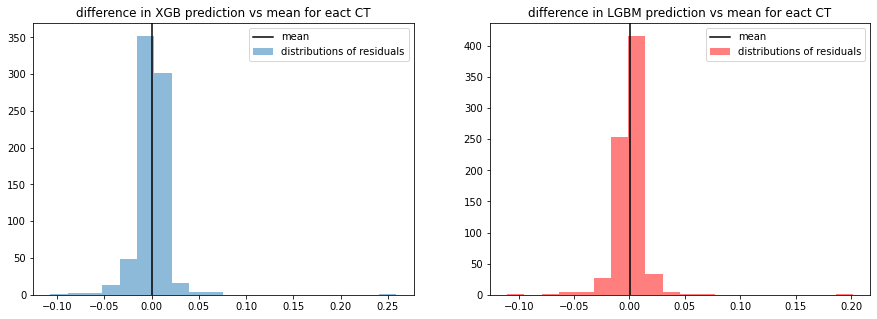

In [ ]:
df_test_pred = df_merged.loc[X_test_normalized.index]
df_test_pred['XGBpred_listings'] = XGB_model_listing.predict(X_test_normalized)
df_test_pred['LGBMpred_listings'] = LGBM_model_listing.predict(X_test_normalized)

XGB_mean_residuals = []
LGBM_mean_residuals = []

for ct in df_test_pred.ct_key.unique():
  mean = np.mean(df_merged[df_merged['ct_key']==ct]['relative_listings_toBaseline'])
  # median = np.median(df_merged[df_merged['ct_key']==ct]['relative_listings_toBaseline'])
  pred_XGB = np.mean(df_test_pred[df_test_pred['ct_key']==ct]['XGBpred_listings'])
  pred_LGBM = np.mean(df_test_pred[df_test_pred['ct_key']==ct]['LGBMpred_listings'])
  XGB_mean_residuals.append(pred_XGB-mean)
  LGBM_mean_residuals.append(pred_LGBM-mean)
  
print(f"XGboost - mean:{np.mean(XGB_mean_residuals):.5f}, st dev:{np.std(XGB_mean_residuals):.5f}")
print(f"LightGBM - mean: {np.mean(LGBM_mean_residuals):.5f}, st dev:{np.std(LGBM_mean_residuals):.5f}")

fig, ax=plt.subplots(1,2,figsize=(15,5))
ax[0].hist(XGB_mean_residuals, bins=20, alpha=0.5, label='distributions of residuals')
ax[0].axvline(np.mean(XGB_mean_residuals), c='k', label='mean')
ax[0].legend()
ax[0].set_title("difference in XGB prediction vs mean for eact CT")

ax[1].hist(LGBM_mean_residuals, bins=20, alpha=0.5, color='r', label='distributions of residuals')
ax[1].axvline(np.mean(LGBM_mean_residuals), c='k', label='mean')
ax[1].legend()
ax[1].set_title("difference in LGBM prediction vs mean for eact CT")
plt.show()

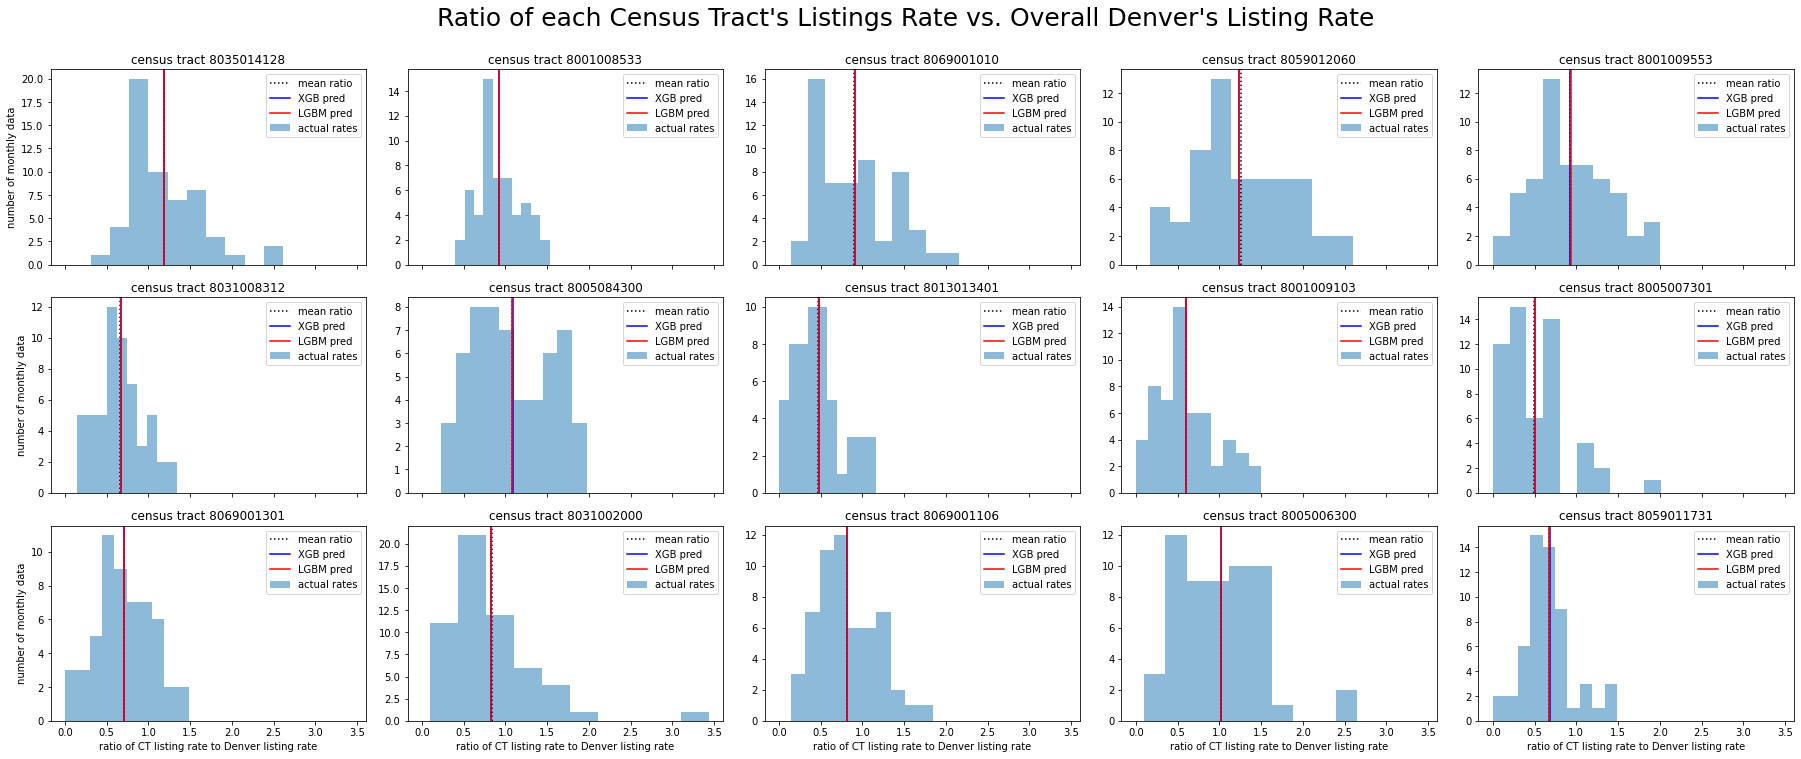

In [ ]:
# take 15 random test points, and plot the predicted rate of sales/households (compared to the distributions of known rate)
np.random.seed(100)

fig, ax = plt.subplots(3,5, sharex=True, figsize=(25,10))
fig.suptitle("Ratio of each Census Tract's Listings Rate vs. Overall Denver's Listing Rate", fontsize=25, y=1.05)
for idx, ct in enumerate(np.random.choice(df_test_pred.ct_key.unique(), 15, replace=False)):
  ax[idx//5, idx%5].set_title(f"census tract {ct}")

  # plot the distribution of known rates
  ax[idx//5, idx%5].hist(df_merged[df_merged['ct_key']==ct]['relative_listings_toBaseline'], alpha=0.5, label='actual rates')
  ax[idx//5, idx%5].axvline(np.mean(df_merged[df_merged['ct_key']==ct]['relative_listings_toBaseline']), c='k', linestyle=':', label='mean ratio')

  # plot the prediction
  pred = df_test_pred[df_test_pred['ct_key']==ct]['XGBpred_listings'].values
  ax[idx//5, idx%5].axvline(np.mean(pred), c='b',label='XGB pred') #taking the mean because we can have > 1 test points belonging to the same census tract
  ax[idx//5, idx%5].legend()

  pred = df_test_pred[df_test_pred['ct_key']==ct]['LGBMpred_listings'].values
  ax[idx//5, idx%5].axvline(np.mean(pred), c='r',label='LGBM pred') #taking the mean because we can have > 1 test points belonging to the same census tract
  ax[idx//5, idx%5].legend()

  # axis label
  if idx//5 == 2: ax[idx//5, idx%5].set_xlabel("ratio of CT listing rate to Denver listing rate")
  if idx%5 == 0: ax[idx//5, idx%5].set_ylabel("number of monthly data")

plt.tight_layout()

#### Visualization

##### Feature Importance

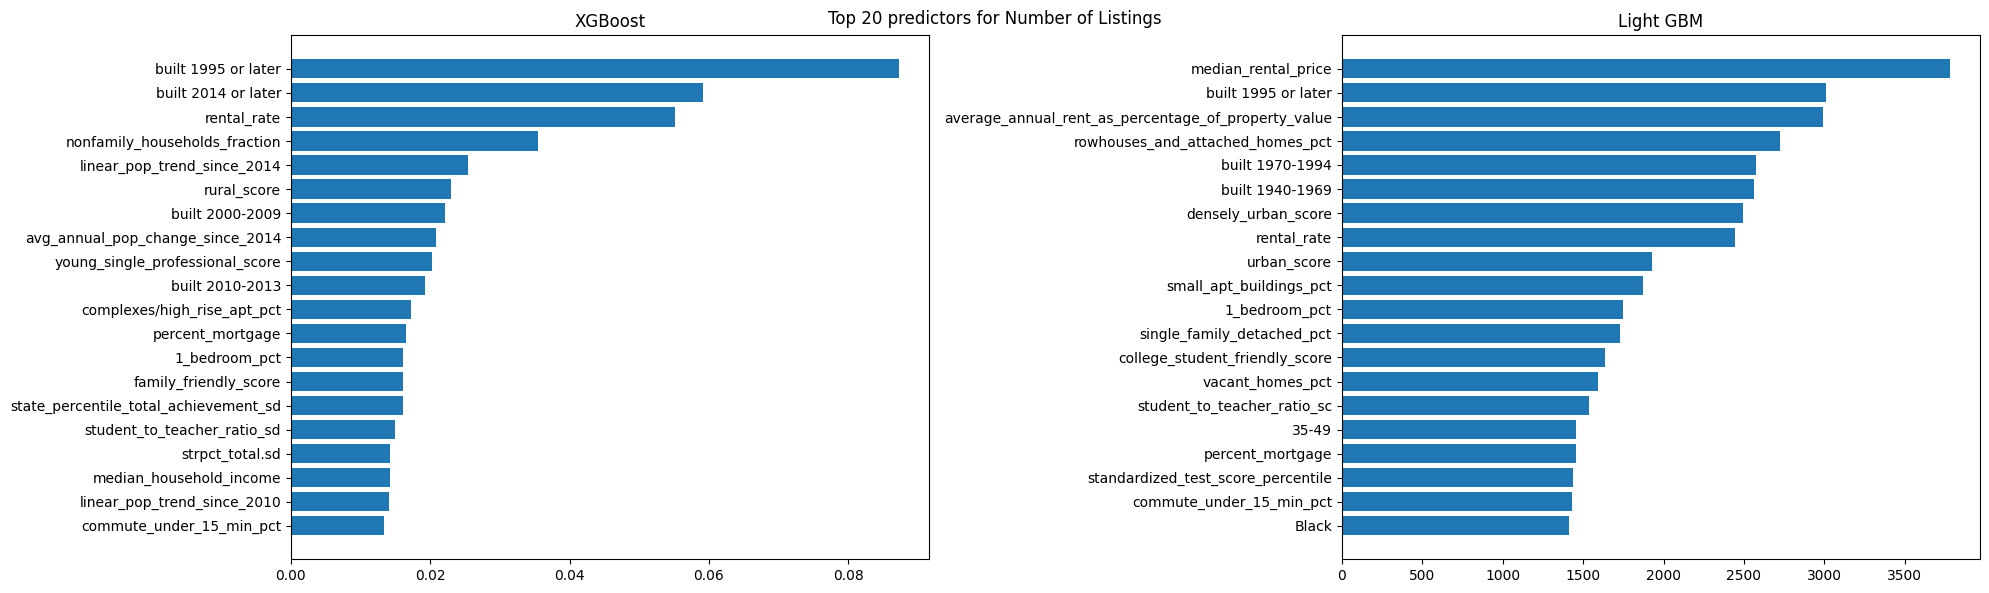

In [ ]:
fig, ax = plt.subplots(1,2, dpi=100,figsize=(20,6))

# XGboost
sorted_idx = XGB_model_listing.feature_importances_.argsort()[::-1][:20]
top20features_XGB = X_train_normalized.columns[sorted_idx][::-1]
ax[0].barh(top20features_XGB, XGB_model_listing.feature_importances_[sorted_idx][::-1])
ax[0].set_title("XGBoost")

# LightGBM
sorted_idx = LGBM_model_listing.feature_importances_.argsort()[::-1][:20]
top20features_LGBM = X_train_normalized.columns[sorted_idx][::-1]
ax[1].barh(top20features_LGBM, LGBM_model_listing.feature_importances_[sorted_idx][::-1])
ax[1].set_title("Light GBM")

fig.suptitle("Top 20 predictors for Number of Listings")
plt.tight_layout()

plt.show()

##### Feature Contribution 

Using the idea of XGBoost explainer package from R to build our own visualization:
- every bar indicates how each feature contributes to the final prediction value
- green means positive contribution, red means negative contribution
- final prediction is given by the blue horizontal line

In [ ]:
def plot_contribution(idx, ax, model_top_features, predictions_contrib, X_test = X_test):
  predictions_contrib_sample =  predictions_contrib[idx].flatten()
  intercept = predictions_contrib_sample[-1]
  features = predictions_contrib_sample[:-1]
  # sorted_idx = np.argsort(abs(features))[::-1][:30]
  sorted_idx = model_top_features
  sorted_features = features[sorted_idx]

  # intercept bar
  ax.bar(0, intercept, bottom=0., width=0.9, color="green" if intercept> 0 else "red", edgecolor='black')
  this_bottom = intercept
  # all variable bars
  for i in range(len(sorted_features)):
      next_bottom = this_bottom + sorted_features[i]
      ax.bar(i+1, next_bottom-this_bottom, bottom=this_bottom, width=0.9,
              color="green" if next_bottom>this_bottom else "red", edgecolor='black')
      this_bottom = next_bottom
  
  # horizontal line for final prediction
  final_pred = predictions_contrib_sample.sum()
  label = f"final prediction = {final_pred:.3f}"
  ax.axhline(final_pred, c='k', linestyle='--', label=label)

  labels = ["intercept"]+list(X_test.columns[sorted_idx])
  ax.set_xticks(np.arange(len(sorted_features)+1))
  ax.set_xticklabels(labels, rotation=90)
  ax.legend()

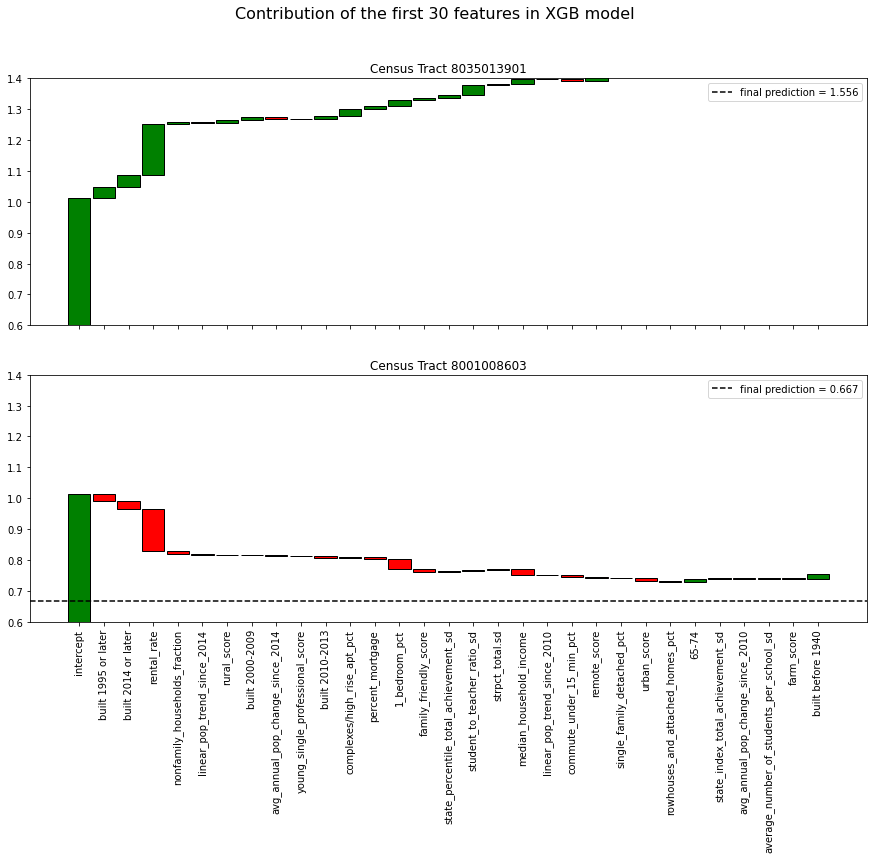

In [ ]:
# output prediction (contribution of each feature for each test data)
booster = XGB_model_listing.get_booster()
test_X = DMatrix(X_test_normalized, feature_names=X_test_normalized.columns)
listing_predictions_contrib_XGB = booster.predict(test_X, pred_contribs=True)

# plot contribution
n_features = 30
fig, axes = plt.subplots(2,1, figsize=(15,10), sharex=True, sharey=True)
fig.suptitle(f"Contribution of the first {n_features} features in XGB model", fontsize=16)
top_features = XGB_model_listing.feature_importances_.argsort()[::-1][:n_features] #select top 30 features chosen by XGB model

sample_idx = [10,20]
axes[0].set_title(f"Census Tract {df_test_pred.iloc[sample_idx[0]]['ct_key']}")
axes[0].set_ylim([0.6,1.4])
plot_contribution(sample_idx[0], axes[0], top_features, listing_predictions_contrib_XGB)
axes[1].set_title(f"Census Tract {df_test_pred.iloc[sample_idx[1]]['ct_key']}")
axes[1].set_ylim([0.6,1.4])
plot_contribution(sample_idx[1], axes[1], top_features, listing_predictions_contrib_XGB)

In [ ]:
X_test.iloc[sample_idx, top_features]

,built 1995 or later,built 2014 or later,rental_rate,nonfamily_households_fraction,linear_pop_trend_since_2014,rural_score,built 2000-2009,avg_annual_pop_change_since_2014,young_single_professional_score,built 2010-2013,complexes/high_rise_apt_pct,percent_mortgage,1_bedroom_pct,family_friendly_score,state_percentile_total_achievement_sd,student_to_teacher_ratio_sd,strpct_total.sd,median_household_income,linear_pop_trend_since_2010,commute_under_15_min_pct,remote_score,single_family_detached_pct,urban_score,rowhouses_and_attached_homes_pct,65-74,state_index_total_achievement_sd,avg_annual_pop_change_since_2010,average_number_of_students_per_school_sd,farm_score,built before 1940
25701,29.560811,0.041554,21.650668,0.263825,0.031452,10.0,0.209797,0.026144,44.456992,0.044257,20.743243,0.789403,9.898649,18.492397,87.928098,18.685070,91.803279,118603,0.042197,16.574294,20.0,77.432432,60.0,0.000000,0.111451,10.0,0.028753,726.784946,100.0,0.000000
2064,23.321123,0.000000,63.246753,0.409091,-0.045552,58.0,0.227106,-0.045525,52.238180,0.006105,24.786325,0.749117,19.658120,78.988974,42.926522,22.115884,47.540984,37688,-0.006198,25.431530,68.0,58.485958,12.0,8.302808,0.035518,5.0,-0.001187,646.241379,100.0,31.013431


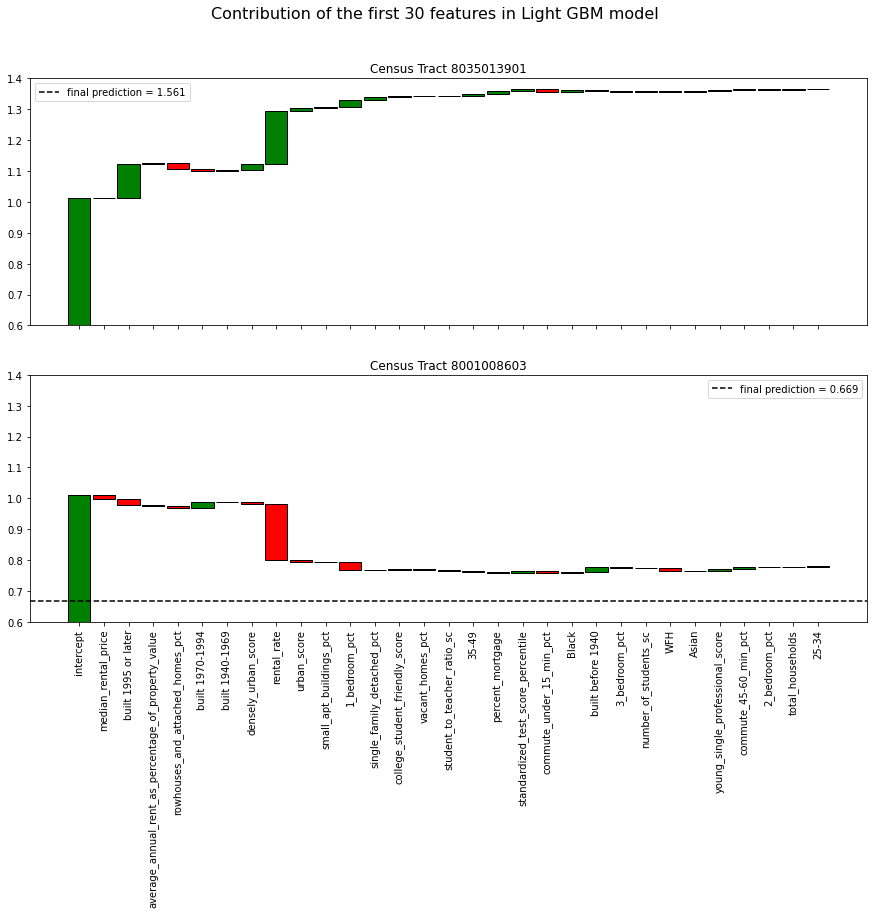

In [ ]:
# output prediction (contribution of each feature for each test data)
listing_predictions_contrib_LGBM = LGBM_model_listing.predict(X_test_normalized, pred_contrib=True)

# plot contribution
fig, axes = plt.subplots(2,1, figsize=(15,10), sharex=True, sharey=True)
fig.suptitle(f"Contribution of the first {n_features} features in Light GBM model", fontsize=16)
top_features = LGBM_model_listing.feature_importances_.argsort()[::-1][:30] #select top 30 features chosen by XGB model

sample_idx = [10,20]
axes[0].set_title(f"Census Tract {df_test_pred.iloc[sample_idx[0]]['ct_key']}")
axes[0].set_ylim([0.6,1.4])
plot_contribution(10,axes[0], top_features, listing_predictions_contrib_LGBM)
axes[1].set_title(f"Census Tract {df_test_pred.iloc[sample_idx[1]]['ct_key']}")
axes[1].set_ylim([0.6,1.4])
plot_contribution(20,axes[1], top_features, listing_predictions_contrib_LGBM)

### Predict Ratio of Home Sales Rate

In [ ]:
y = df_merged['relative_sales_toBaseline'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=percent_unique, random_state=100, stratify = df_merged.ct_key)

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_train_normalized = pd.DataFrame(X_train_normalized, index=X_train.index, columns=X_train.columns)
display(X_train_normalized.head())

X_test_normalized = scaler.transform(X_test)
X_test_normalized = pd.DataFrame(X_test_normalized, index=X_test.index, columns=X_test.columns)


,median_rental_price,average_annual_rent_as_percentage_of_property_value,farm_score,densely_urban_score,urban_score,suburban_score,rural_score,remote_score,built 1995 or later,built 1970-1994,built 1940-1969,built before 1940,single_family_detached_pct,rowhouses_and_attached_homes_pct,small_apt_buildings_pct,complexes/high_rise_apt_pct,mobile_home_pct,0_bedroom_pct,1_bedroom_pct,2_bedroom_pct,3_bedroom_pct,4_bedroom_pct,5_bedroom_pct,rental_rate,seasonal_housing_pct,vacant_homes_pct,family_friendly_score,first_time_homebuyer_score,luxury_communities_score,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,commute_under_15_min_pct,commute_15-30_min_pct,commute_30-45_min_pct,commute_45-60_min_pct,commute_over_60_min_pct,violent_crime_rate,property_crime_rate,standardized_test_score_percentile,...,avg_annual_pop_change_since_2010,linear_pop_trend_since_2014,avg_annual_pop_change_since_2014,annual_births_per_resident,workforce_fraction,car,carpool,public_transportation,walk,WFH,other_mode_of_transit,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,nonfamily_households_fraction,STEM_jobs,education&health_care,total_households,avg_family_size,avg_nonfamily_size,avg_household_size,lessthan200k,200-300k,300-400k,400-500k,500-750k,750-1000k,greaterthan1M,married,divorced/separated/widowed,never_married,percent_mortgage,median_mortgage_value,vacancy_rate,built 2014 or later,built 2010-2013,built 2000-2009
5899,0.285714,0.088069,1.0,0.625000,0.544304,0.000000,0.302326,0.375000,0.313040,0.557370,0.133337,0.003449,0.657870,0.052615,0.000000,0.315529,0.000000,0.000000,0.184076,0.337960,0.163000,0.443438,0.492418,0.340304,0.012965,0.020634,0.168225,1.000000,0.060486,0.004169,0.429471,0.564607,0.350838,0.509441,0.457869,0.260130,0.087873,0.000000,0.002317,0.950744,...,0.213101,0.520575,0.567949,0.051293,0.545229,0.806939,0.149492,0.208415,0.015244,0.455651,0.025375,0.398145,0.484574,0.182432,0.470979,0.508055,0.424222,0.199387,0.543919,0.205714,0.108104,0.268657,0.051136,0.375000,0.022019,0.008785,0.007785,0.080767,0.338986,0.652844,0.498105,0.793011,0.188017,0.200241,0.494835,0.489119,0.020634,0.301529,0.028933,0.180476
2309,0.103338,0.199773,1.0,0.239583,0.075949,0.378378,0.732558,0.760417,0.043437,0.180508,0.798349,0.007157,0.702086,0.093252,0.175765,0.065273,0.160742,0.118607,0.089122,0.391357,0.502738,0.269330,0.130795,0.428468,0.000000,0.074033,0.665598,0.410896,0.904497,0.917233,0.813718,0.818306,0.383190,0.579268,0.466495,0.120789,0.065243,0.325178,0.035851,0.101870,...,0.448721,0.572351,0.648914,0.661964,0.441241,0.754064,0.517223,0.153013,0.000000,0.235563,0.000000,0.103600,0.130518,0.069804,0.063306,0.053566,0.068172,0.205892,0.331081,0.266667,0.174303,0.835821,0.079545,0.791667,0.596221,0.324798,0.241266,0.000000,0.000000,0.000000,0.075878,0.493280,0.361570,0.367913,0.564736,0.073614,0.074033,0.000000,0.000000,0.045841
13422,0.346834,0.031332,1.0,0.250000,0.088608,0.351351,0.720930,0.750000,0.123484,0.230603,0.385560,0.328853,0.768164,0.136758,0.237082,0.083156,0.000000,0.000000,0.155596,0.414873,0.336187,0.384504,0.215555,0.218443,0.000000,0.066059,0.254943,1.000000,0.042210,0.533316,0.379043,0.350375,0.701131,0.415661,0.149729,0.192711,0.270270,0.069224,0.014698,0.812928,...,0.254640,0.328843,0.400759,0.285492,0.627844,0.345996,0.382839,0.323556,0.136408,0.641230,0.578604,0.403184,0.660655,0.188650,0.354521,0.430909,0.497859,0.457786,1.000000,0.257143,0.262351,0.361940,0.255682,0.352564,0.033215,0.018746,0.025206,0.072591,0.291343,0.384788,0.649674,0.637097,0.270661,0.293124,0.467700,0.569251,0.066059,0.000000,0.080706,0.096186
14856,0.716004,0.285188,0.5,0.760417,0.708861,0.162162,0.151163,0.239583,0.008837,0.790694,0.207812,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025369,0.489601,0.775327,0.276857,0.033534,0.015372,0.013761,0.013071,1.000000,0.037025,0.096201,0.562074,0.88891

#### Hyperparameter Tuning

In [ ]:
# find best hyperparameter for ratio of listing rate - XGBOOST

# CAUTION - rerunning the code below for hyperparameter tuning will take >3 hours to run.  
# bestparams_XGB_sales = fmin(fn = XGB_hyperparameter_tuning, space=XGB_space, algo=tpe.suggest, max_evals=50, trials= Trials())
# output:
bestparams_XGB_sales = {'learning_rate': 0.0027967882078209815, 'max_depth': 10.0, 'n_estimators': 1300.0, 'reg_alpha': 5.0, 'reg_lambda': 0.4802083007140269}
print(bestparams_XGB_sales)

{'learning_rate': 0.0027967882078209815, 'max_depth': 10.0, 'n_estimators': 1300.0, 'reg_alpha': 5.0, 'reg_lambda': 0.4802083007140269}


In [ ]:
# find best hyperparameter for ratio of listing rate - Light GBM
# bestparams_LGBM_sales = fmin(fn = LGBM_hyperparameter_tuning, space=LGBM_space, algo=tpe.suggest, max_evals=50, trials= Trials())
# output:
bestparams_LGBM_sales = {'learning_rate': 0.007497020892423993, 'n_estimators': 800.0, 'num_leaves': 56.0, 'reg_alpha': 6.0, 'reg_lambda': 0.16268462381291066}

print(bestparams_LGBM_sales)

{'learning_rate': 0.007497020892423993, 'n_estimators': 800.0, 'num_leaves': 56.0, 'reg_alpha': 6.0, 'reg_lambda': 0.16268462381291066}


#### Build Model with Chosen Hyperparameter

In [ ]:
# Build final XGB model

#'bestparams_XGB_sales' gives the learning rate, max_depth, n_estimators, alpha, lambda
XGB_model_sales = XGBRegressor(learning_rate = bestparams_XGB_sales['learning_rate'], max_depth = int(bestparams_XGB_sales['max_depth']), 
                                 n_estimators = int(bestparams_XGB_sales['n_estimators']),
                                 reg_alpha = int(bestparams_XGB_sales['reg_alpha']), reg_lambda = bestparams_XGB_sales['reg_lambda'], 
                                 min_child_weight = XGB_space['min_child_weight'], 
                                 colsample_bytree = XGB_space['colsample_bytree'], colsample_bylevel = XGB_space['colsample_bylevel'], 
                                 objective = XGB_space['objective'], eval_metric = 'mae', base_score = np.median(y_train))
print(XGB_model_sales)
XGB_model_sales.fit(X_train_normalized,y_train)
print("\nMAE training:", mean_absolute_error(y_train, XGB_model_sales.predict(X_train_normalized)))
print("MAE testing:", mean_absolute_error(y_test, XGB_model_sales.predict(X_test_normalized)))
# MAE training: 0.34636498526731413
# MAE testing: 0.3460421017384895

XGBRegressor(base_score=0.9042659969901782, booster='gbtree',
             colsample_bylevel=0.7, colsample_bynode=1, colsample_bytree=0.62,
             eval_metric='mae', gamma=0, importance_type='gain',
             learning_rate=0.0027967882078209815, max_delta_step=0,
             max_depth=10, min_child_weight=1.12, missing=None,
             n_estimators=1300, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=5,
             reg_lambda=0.4802083007140269, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

MAE training: 0.34636498526731413
MAE testing: 0.3460421017384895


In [ ]:
# Build final LGBM model

#'bestparams_LGBM_listings' gives the learning rate, max_depth, n_estimators, alpha, lambda
LGBM_model_sales = LGBMRegressor(learning_rate = bestparams_LGBM_sales['learning_rate'], num_leaves = int(bestparams_LGBM_sales['num_leaves']), 
                                 n_estimators = int(bestparams_LGBM_sales['n_estimators']),
                                 reg_alpha = int(bestparams_LGBM_sales['reg_alpha']), reg_lambda = bestparams_LGBM_sales['reg_lambda'], 
                                 min_child_weight = LGBM_space['min_child_weight'], 
                                 colsample_bytree = LGBM_space['colsample_bytree'], colsample_bylevel = LGBM_space['colsample_bylevel'], 
                                 objective = LGBM_space['objective'], eval_metric = 'mae')
print(LGBM_model_sales)
LGBM_model_sales.fit(X_train_normalized,y_train)
print("\nMAE training:", mean_absolute_error(y_train, LGBM_model_sales.predict(X_train_normalized)))
print("MAE testing:", mean_absolute_error(y_test, LGBM_model_sales.predict(X_test_normalized)))


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
              colsample_bytree=0.62, eval_metric='mae', importance_type='split',
              learning_rate=0.007497020892423993, max_depth=-1,
              min_child_samples=20, min_child_weight=1.12, min_split_gain=0.0,
              n_estimators=800, n_jobs=-1, num_leaves=56,
              objective='regression', random_state=None, reg_alpha=6,
              reg_lambda=0.16268462381291066, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

MAE training: 0.34582794249712684
MAE testing: 0.34536126550842544


#### Evaluate Model Prediction

XGboost - mean:-0.00282, st dev:0.03904
LightGBM - mean: 0.00106, st dev:0.02661


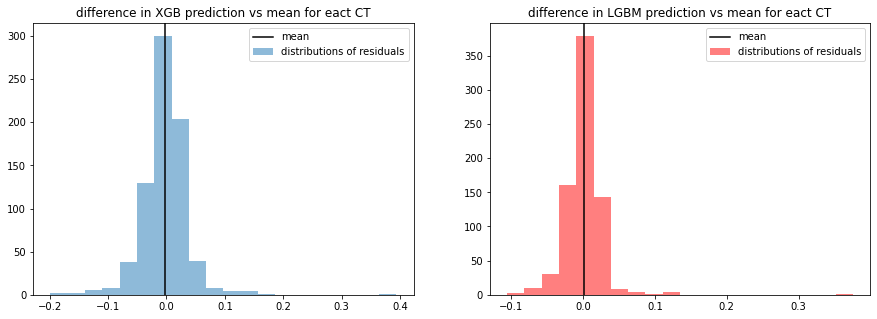

In [ ]:
# df_test_pred = df_merged.loc[X_test_normalized.index]
df_test_pred['XGBpred_sales'] = XGB_model_sales.predict(X_test_normalized)
df_test_pred['LGBMpred_sales'] = LGBM_model_sales.predict(X_test_normalized)

XGB_mean_residuals = []
LGBM_mean_residuals = []

for ct in df_test_pred.ct_key.unique():
  mean = np.mean(df_merged[df_merged['ct_key']==ct]['relative_sales_toBaseline'])
  # median = np.median(df_merged[df_merged['ct_key']==ct]['relative_listings_toBaseline'])
  pred_XGB = np.mean(df_test_pred[df_test_pred['ct_key']==ct]['XGBpred_sales'])
  pred_LGBM = np.mean(df_test_pred[df_test_pred['ct_key']==ct]['LGBMpred_sales'])
  XGB_mean_residuals.append(pred_XGB-mean)
  LGBM_mean_residuals.append(pred_LGBM-mean)

print(f"XGboost - mean:{np.mean(XGB_mean_residuals):.5f}, st dev:{np.std(XGB_mean_residuals):.5f}")
print(f"LightGBM - mean: {np.mean(LGBM_mean_residuals):.5f}, st dev:{np.std(LGBM_mean_residuals):.5f}")

fig, ax=plt.subplots(1,2,figsize=(15,5))
ax[0].hist(XGB_mean_residuals, bins=20, alpha=0.5, label='distributions of residuals')
ax[0].axvline(np.mean(XGB_mean_residuals), c='k', label='mean')
ax[0].legend()
ax[0].set_title("difference in XGB prediction vs mean for eact CT")

ax[1].hist(LGBM_mean_residuals, bins=20, alpha=0.5, color='r', label='distributions of residuals')
ax[1].axvline(np.mean(LGBM_mean_residuals), c='k', label='mean')
ax[1].legend()
ax[1].set_title("difference in LGBM prediction vs mean for eact CT")

plt.show()

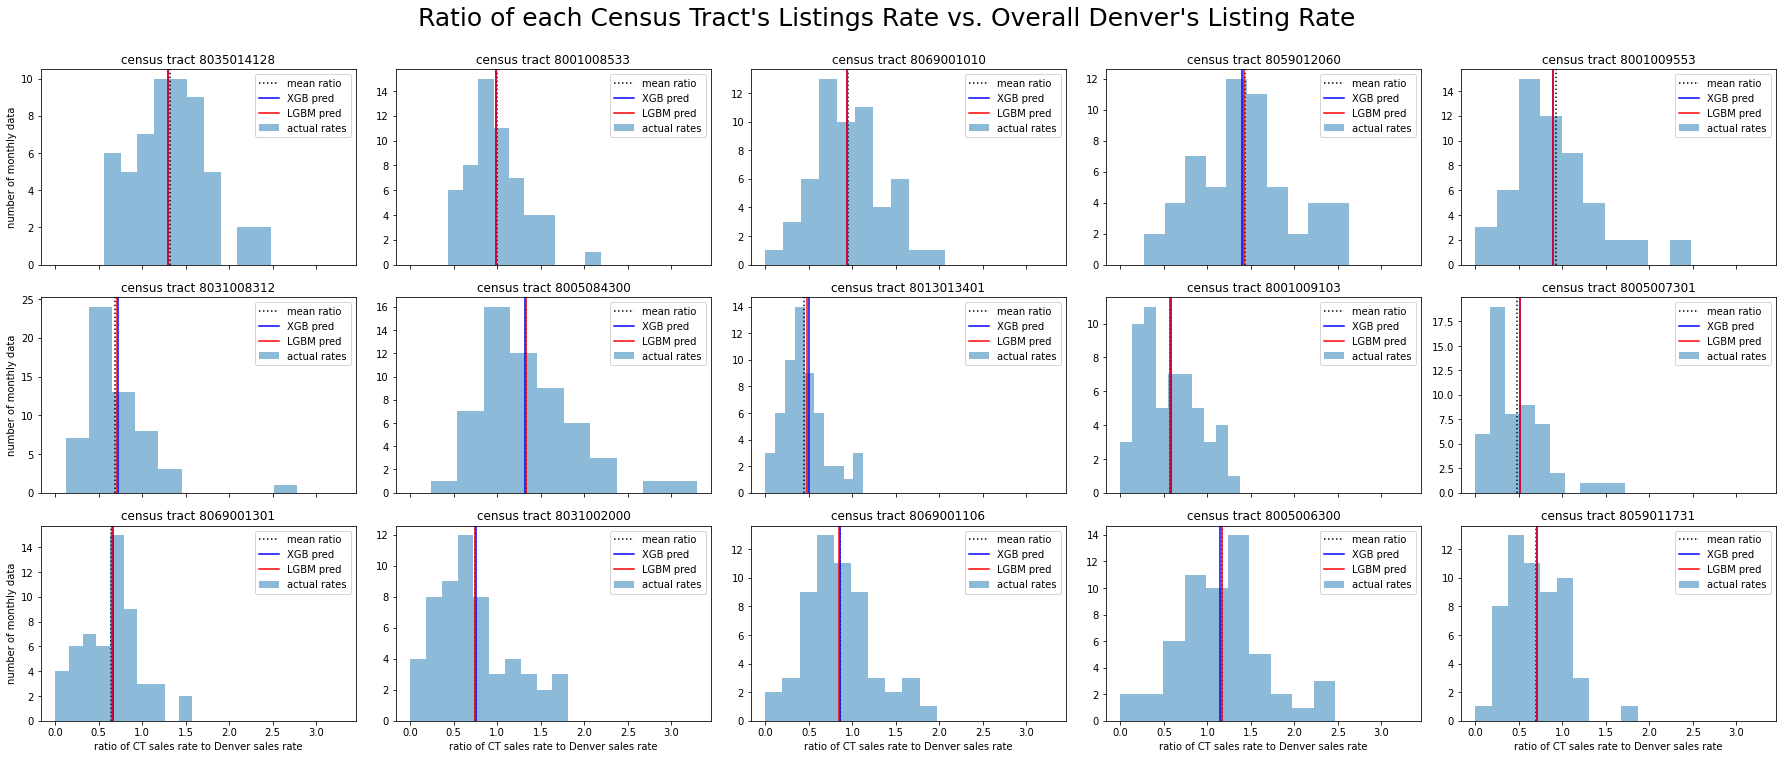

In [ ]:
# take 15 random test points, and plot the predicted rate of sales/households (compared to the distributions of known rate)
np.random.seed(100)
fig, ax = plt.subplots(3,5, sharex=True, figsize=(25,10))
fig.suptitle("Ratio of each Census Tract's Listings Rate vs. Overall Denver's Listing Rate", fontsize=25, y=1.05)
for idx, ct in enumerate(np.random.choice(df_test_pred.ct_key.unique(), 15, replace=False)):
  ax[idx//5, idx%5].set_title(f"census tract {ct}")

  # plot the distribution of known rates
  ax[idx//5, idx%5].hist(df_merged[df_merged['ct_key']==ct]['relative_sales_toBaseline'], alpha=0.5, label='actual rates')
  ax[idx//5, idx%5].axvline(np.mean(df_merged[df_merged['ct_key']==ct]['relative_sales_toBaseline']), c='k', linestyle=':', label='mean ratio')
  
  # plot the prediction
  pred = df_test_pred[df_test_pred['ct_key']==ct]['XGBpred_sales'].values
  ax[idx//5, idx%5].axvline(np.mean(pred), c='b',label='XGB pred') #taking the mean because we can have > 1 test points belonging to the same census tract
  ax[idx//5, idx%5].legend()

  # plot the prediction
  pred = df_test_pred[df_test_pred['ct_key']==ct]['LGBMpred_sales'].values
  ax[idx//5, idx%5].axvline(np.mean(pred), c='r',label='LGBM pred') #taking the mean because we can have > 1 test points belonging to the same census tract
  ax[idx//5, idx%5].legend()


  # axis label
  if idx//5 == 2: ax[idx//5, idx%5].set_xlabel("ratio of CT sales rate to Denver sales rate")
  if idx%5 == 0: ax[idx//5, idx%5].set_ylabel("number of monthly data")

plt.tight_layout()

#### Visualization

##### Feature Importance

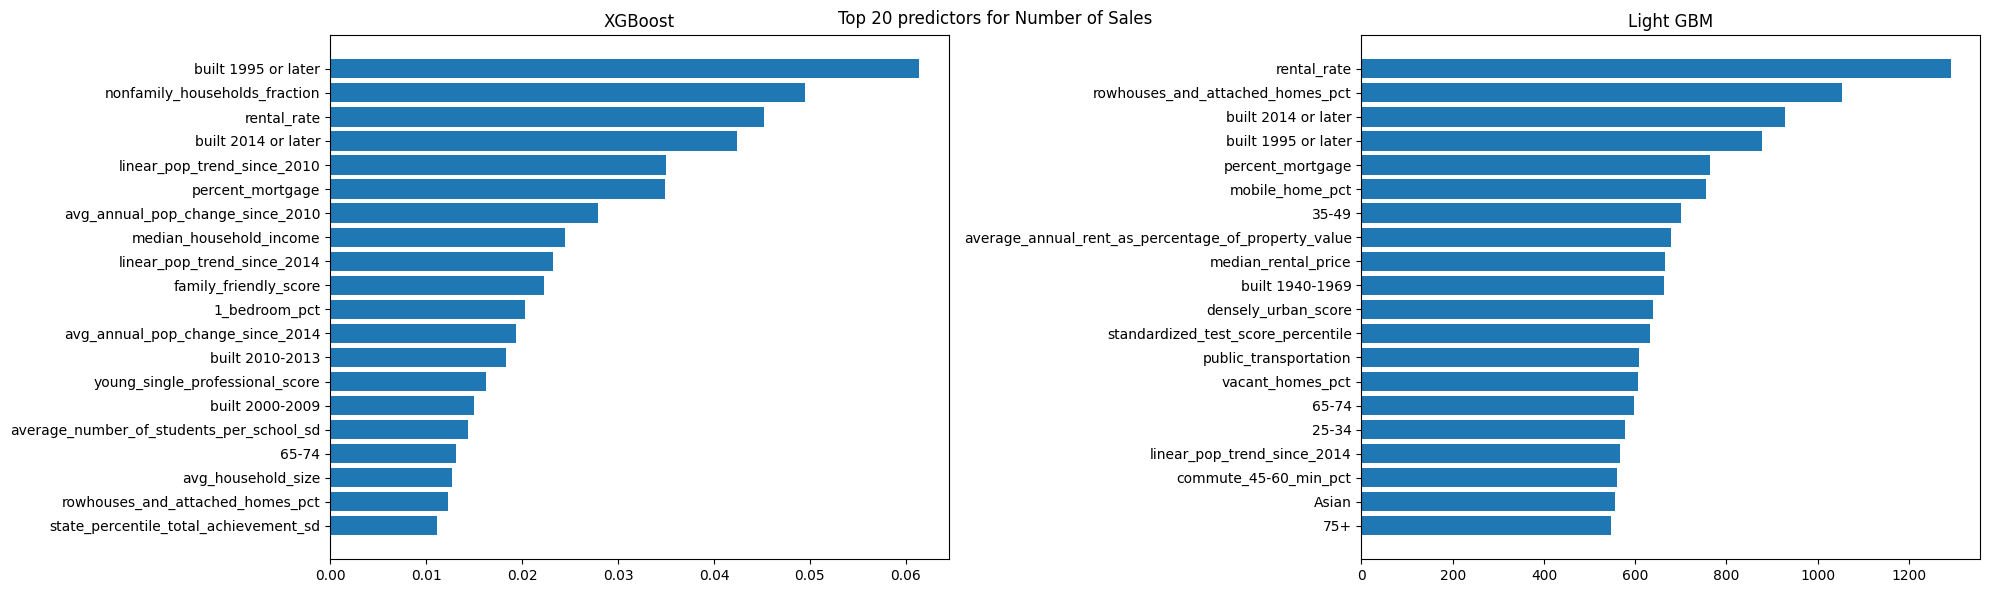

In [ ]:
fig, ax = plt.subplots(1,2, dpi=100,figsize=(20,6))

# XGboost
sorted_idx = XGB_model_sales.feature_importances_.argsort()[::-1][:20]
ax[0].barh(np.arange(20), XGB_model_sales.feature_importances_[sorted_idx][::-1])
ax[0].set_yticks(np.arange(20))
ax[0].set_yticklabels([col for col in X_train_normalized.columns[sorted_idx]][::-1])
ax[0].set_title("XGBoost")

# LightGBM
sorted_idx = LGBM_model_sales.feature_importances_.argsort()[::-1][:20]
ax[1].barh(np.arange(20), LGBM_model_sales.feature_importances_[sorted_idx][::-1])
ax[1].set_yticks(np.arange(20))
ax[1].set_yticklabels([col for col in X_train_normalized.columns[sorted_idx]][::-1])
ax[1].set_title("Light GBM")

fig.suptitle("Top 20 predictors for Number of Sales")
plt.tight_layout()
plt.show()

##### Feature Contribution

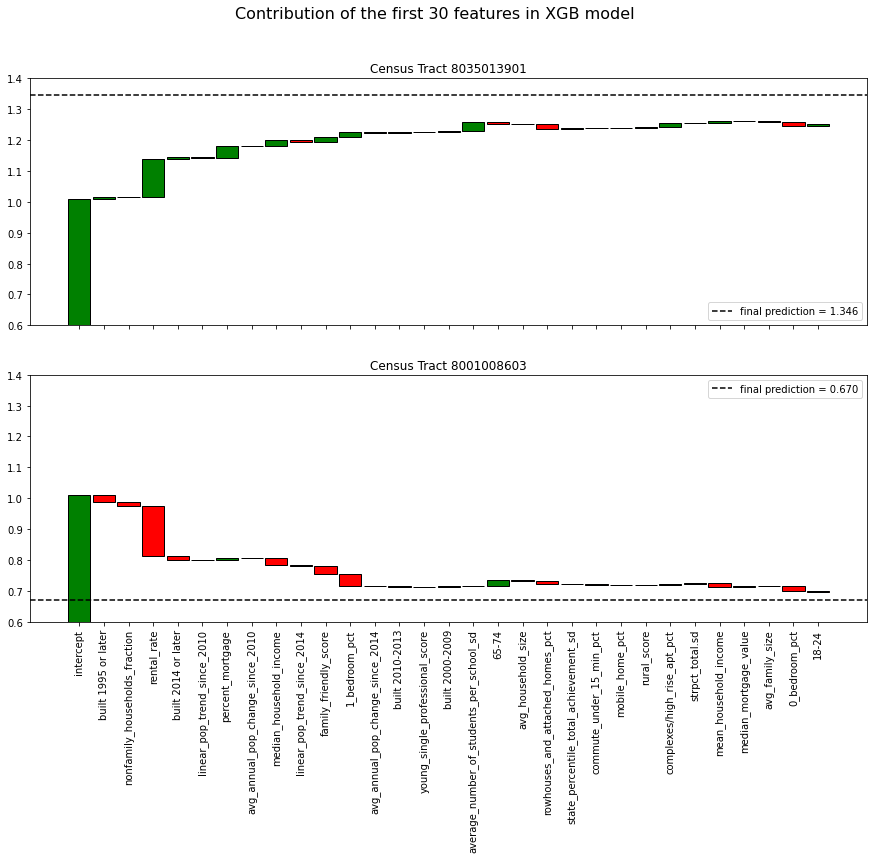

In [ ]:
# output prediction (contribution of each feature for each test data)
booster = XGB_model_sales.get_booster()
test_X = DMatrix(X_test_normalized, feature_names=X_test_normalized.columns)
sales_predictions_contrib_XGB = booster.predict(test_X, pred_contribs=True)

# plot contribution
n_features = 30
fig, axes = plt.subplots(2,1, figsize=(15,10), sharex=True, sharey=True)
fig.suptitle(f"Contribution of the first {n_features} features in XGB model", fontsize=16)
top_features = XGB_model_sales.feature_importances_.argsort()[::-1][:n_features] #select top 30 features chosen by XGB model

sample_idx = [10,20]
axes[0].set_title(f"Census Tract {df_test_pred.iloc[sample_idx[0]]['ct_key']}")
axes[0].set_ylim([0.6,1.4])
plot_contribution(sample_idx[0], axes[0], top_features, sales_predictions_contrib_XGB)
axes[1].set_title(f"Census Tract {df_test_pred.iloc[sample_idx[1]]['ct_key']}")
axes[1].set_ylim([0.6,1.4])
plot_contribution(sample_idx[1], axes[1], top_features, sales_predictions_contrib_XGB)

In [ ]:
X_test.iloc[sample_idx, top_features]

,rental_rate,rowhouses_and_attached_homes_pct,built 2014 or later,built 1995 or later,percent_mortgage,mobile_home_pct,35-49,average_annual_rent_as_percentage_of_property_value,median_rental_price,built 1940-1969,densely_urban_score,standardized_test_score_percentile,public_transportation,vacant_homes_pct,65-74,25-34,linear_pop_trend_since_2014,commute_45-60_min_pct,Asian,75+,commute_30-45_min_pct,student_to_teacher_ratio_sc,0_bedroom_pct,lessthan200k,built 1970-1994,college_student_friendly_score,60-64,18-24,1_bedroom_pct,3_bedroom_pct
25701,21.650668,0.000000,0.041554,29.560811,0.789403,1.824324,0.235654,7.369875,2083.0,5.777027,80.0,70.394977,0.016543,4.087838,0.111451,0.094182,0.031452,13.248878,0.017269,0.051541,32.673529,17.695643,1.047297,0.023095,64.662162,96.558883,0.067880,0.073459,9.898649,22.128378
2064,63.246753,8.302808,0.000000,23.321123,0.749117,0.976801,0.206103,10.038674,1441.0,33.577534,32.0,33.049319,0.009901,5.982906,0.035518,0.186093,-0.045552,24.395857,0.007004,0.043522,22.554661,14.977974,2.075702,0.766537,12.087912,66.157992,0.045523,0.082041,19.658120,34.188034


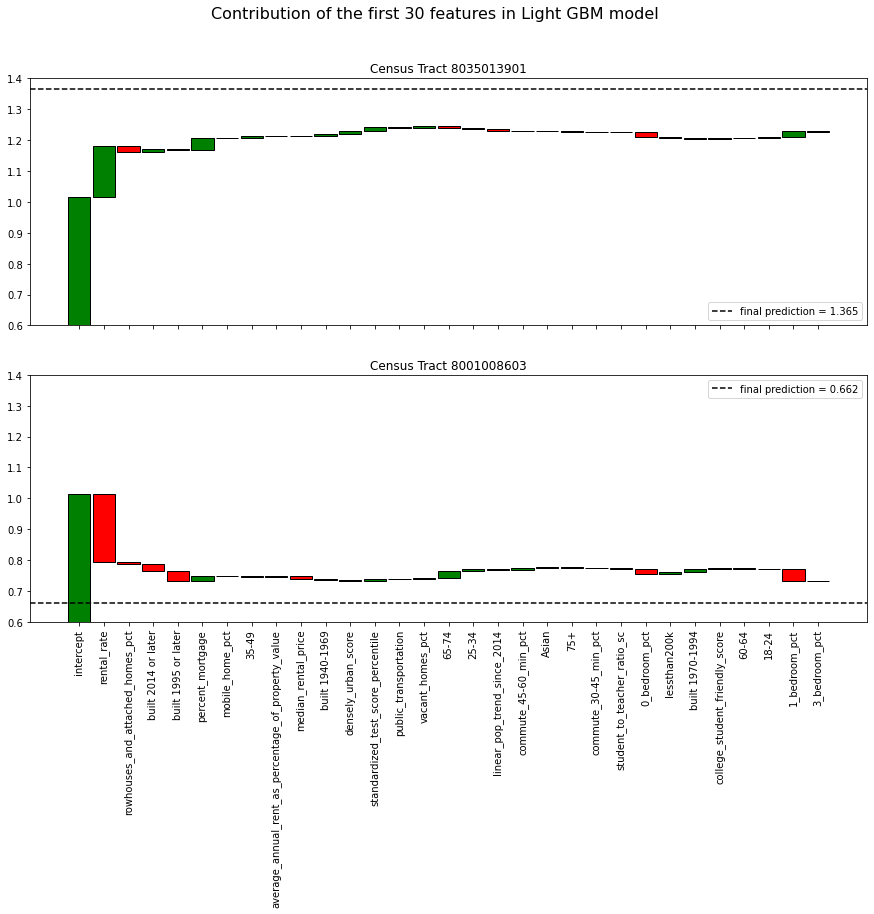

In [ ]:
# sales_predictions_contrib_LGBM = LGBM_model_sales.predict(X_test_normalized, pred_contrib=True)

# plot contribution
fig, axes = plt.subplots(2,1, figsize=(15,10), sharex=True, sharey=True)
fig.suptitle(f"Contribution of the first {n_features} features in Light GBM model", fontsize=16)
top_features = LGBM_model_sales.feature_importances_.argsort()[::-1][:30] #select top 30 features chosen by XGB model

sample_idx = [10,20]
axes[0].set_title(f"Census Tract {df_test_pred.iloc[sample_idx[0]]['ct_key']}")
axes[0].set_ylim([0.6,1.4])
plot_contribution(10,axes[0], top_features, sales_predictions_contrib_LGBM)
axes[1].set_title(f"Census Tract {df_test_pred.iloc[sample_idx[1]]['ct_key']}")
axes[1].set_ylim([0.6,1.4])
plot_contribution(20,axes[1], top_features, sales_predictions_contrib_LGBM)

### Sensitivity

#### Vary Testing vs Training size

In [ ]:
y = df_merged['relative_listings_toBaseline'].values

training_MAE_listings = defaultdict(list)
testing_MAE_listings = defaultdict(list)
test_size_factors = np.arange(1,10,2)
# try out smaller training size and larger testing size (held out 1,2,3,... data per CT)
for test_size_factor in test_size_factors:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_factor*percent_unique, random_state=100, stratify = df_merged.ct_key)
  
  scaler = MinMaxScaler()
  X_train_normalized = scaler.fit_transform(X_train)
  X_train_normalized = pd.DataFrame(X_train_normalized, index=X_train.index, columns=X_train.columns)
  X_test_normalized = scaler.transform(X_test)
  X_test_normalized = pd.DataFrame(X_test_normalized, index=X_test.index, columns=X_test.columns)
  
  # XGboost
  XGB_model_listing = XGBRegressor(learning_rate = bestparams_XGB_listings['learning_rate'], max_depth = int(bestparams_XGB_listings['max_depth']), 
                                  n_estimators = int(bestparams_XGB_listings['n_estimators']),
                                  reg_alpha = int(bestparams_XGB_listings['reg_alpha']), reg_lambda = bestparams_XGB_listings['reg_lambda'], 
                                  min_child_weight = XGB_space['min_child_weight'], 
                                  colsample_bytree = XGB_space['colsample_bytree'], colsample_bylevel = XGB_space['colsample_bylevel'], 
                                  objective = XGB_space['objective'], eval_metric = 'mae', base_score = np.median(y_train))
  XGB_model_listing.fit(X_train_normalized,y_train)

  training_MAE_listings['XGB'].append(mean_absolute_error(y_train, XGB_model_listing.predict(X_train_normalized)))
  testing_MAE_listings['XGB'].append(mean_absolute_error(y_test, XGB_model_listing.predict(X_test_normalized)))

  # Light GBM
  LGBM_model_listing=LGBMRegressor(learning_rate = bestparams_LGBM_listings['learning_rate'], num_leaves = int(bestparams_LGBM_listings['num_leaves']), 
                                  n_estimators = int(bestparams_LGBM_listings['n_estimators']),
                                  reg_alpha = int(bestparams_LGBM_listings['reg_alpha']), reg_lambda = bestparams_LGBM_listings['reg_lambda'], 
                                  min_child_weight = LGBM_space['min_child_weight'], 
                                  colsample_bytree = LGBM_space['colsample_bytree'], colsample_bylevel = LGBM_space['colsample_bylevel'], 
                                  objective = LGBM_space['objective'], eval_metric = 'mae')

  LGBM_model_listing.fit(X_train_normalized,y_train)

  training_MAE_listings['LGBM'].append(mean_absolute_error(y_train, LGBM_model_listing.predict(X_train_normalized)))
  testing_MAE_listings['LGBM'].append(mean_absolute_error(y_test, LGBM_model_listing.predict(X_test_normalized)))


In [ ]:
y = df_merged['relative_sales_toBaseline'].values

training_MAEs_sales = defaultdict(list)
testing_MAEs_sales = defaultdict(list)

for test_size_factor in test_size_factors:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_factor*percent_unique, random_state=100, stratify = df_merged.ct_key)
  
  scaler = MinMaxScaler()
  X_train_normalized = scaler.fit_transform(X_train)
  X_train_normalized = pd.DataFrame(X_train_normalized, index=X_train.index, columns=X_train.columns)
  X_test_normalized = scaler.transform(X_test)
  X_test_normalized = pd.DataFrame(X_test_normalized, index=X_test.index, columns=X_test.columns)

  # XGboost
  XGB_model_sales = XGBRegressor(learning_rate = bestparams_XGB_sales['learning_rate'], max_depth = int(bestparams_XGB_sales['max_depth']), 
                                  n_estimators = int(bestparams_XGB_sales['n_estimators']),
                                  reg_alpha = int(bestparams_XGB_sales['reg_alpha']), reg_lambda = bestparams_XGB_sales['reg_lambda'], 
                                  min_child_weight = XGB_space['min_child_weight'], 
                                  colsample_bytree = XGB_space['colsample_bytree'], colsample_bylevel = XGB_space['colsample_bylevel'], 
                                  objective = XGB_space['objective'], eval_metric = 'mae', base_score = np.median(y_train))
  XGB_model_sales.fit(X_train_normalized,y_train)

  training_MAEs_sales['XGB'].append(mean_absolute_error(y_train, XGB_model_sales.predict(X_train_normalized)))
  testing_MAEs_sales['XGB'].append(mean_absolute_error(y_test, XGB_model_sales.predict(X_test_normalized)))

  # Light GBM
  LGBM_model_sales =LGBMRegressor(learning_rate = bestparams_LGBM_sales['learning_rate'], num_leaves = int(bestparams_LGBM_sales['num_leaves']), 
                                  n_estimators = int(bestparams_LGBM_sales['n_estimators']),
                                  reg_alpha = int(bestparams_LGBM_sales['reg_alpha']), reg_lambda = bestparams_LGBM_sales['reg_lambda'], 
                                  min_child_weight = LGBM_space['min_child_weight'], 
                                  colsample_bytree = LGBM_space['colsample_bytree'], colsample_bylevel = LGBM_space['colsample_bylevel'], 
                                  objective = LGBM_space['objective'], eval_metric = 'mae')

  LGBM_model_sales.fit(X_train_normalized,y_train)

  training_MAEs_sales['LGBM'].append(mean_absolute_error(y_train, LGBM_model_sales.predict(X_train_normalized)))
  testing_MAEs_sales['LGBM'].append(mean_absolute_error(y_test, LGBM_model_sales.predict(X_test_normalized)))


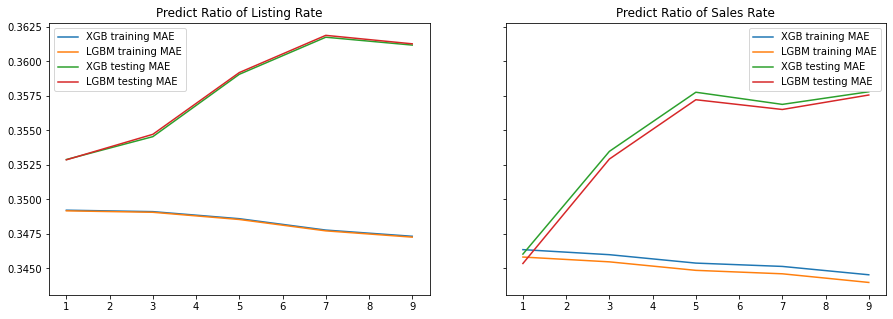

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5), sharex=True, sharey=True)
ax[0].set_title("Predict Ratio of Listing Rate")
ax[0].plot(test_size_factors, training_MAE_listings['XGB'], label='XGB training MAE')
ax[0].plot(test_size_factors, training_MAE_listings['LGBM'], label='LGBM training MAE')
ax[0].plot(test_size_factors, testing_MAE_listings['XGB'], label='XGB testing MAE')
ax[0].plot(test_size_factors, testing_MAE_listings['LGBM'], label='LGBM testing MAE')
ax[0].legend()
ax[1].set_title("Predict Ratio of Sales Rate")
ax[1].plot(test_size_factors, training_MAEs_sales['XGB'], label='XGB training MAE')
ax[1].plot(test_size_factors, training_MAEs_sales['LGBM'], label='LGBM training MAE')
ax[1].plot(test_size_factors, testing_MAEs_sales['XGB'], label='XGB testing MAE')
ax[1].plot(test_size_factors, testing_MAEs_sales['LGBM'], label='LGBM testing MAE')
ax[1].legend()

In [ ]:
SalesRate_MAE = pd.concat([pd.DataFrame({'test_data_size':test_size_factors}),
                           pd.DataFrame(training_MAEs_sales).rename(columns={'XGB':'trainingMAE_XGB', 'LGBM':'trainingMAE_LGBM'}), 
                           pd.DataFrame(testing_MAEs_sales).rename(columns={'XGB':'testingMAE_XGB', 'LGBM':'testingMAE_LGBM'})], axis=1)
ListingRate_MAE = pd.concat([pd.DataFrame({'test_data_size':test_size_factors}),
                             pd.DataFrame(training_MAE_listings).rename(columns={'XGB':'trainingMAE_XGB', 'LGBM':'trainingMAE_LGBM'}), 
                             pd.DataFrame(testing_MAE_listings).rename(columns={'XGB':'testingMAE_XGB', 'LGBM':'testingMAE_LGBM'})], axis=1)

print("listing rate")
display(ListingRate_MAE)

print("sales rate")
display(SalesRate_MAE)

listing rate


,test_data_size,trainingMAE_XGB,trainingMAE_LGBM,testingMAE_XGB,testingMAE_LGBM
0,1,0.349223,0.349176,0.352894,0.352874
1,3,0.349119,0.349071,0.354552,0.354720
2,5,0.348607,0.348550,0.359069,0.359195
3,7,0.347783,0.347725,0.361756,0.361892
4,9,0.347333,0.347270,0.361187,0.361279


sales rate


,test_data_size,trainingMAE_XGB,trainingMAE_LGBM,testingMAE_XGB,testingMAE_LGBM
0,1,0.346365,0.345828,0.346042,0.345361
1,3,0.345999,0.345480,0.353485,0.352930
2,5,0.345389,0.344864,0.357770,0.357226
3,7,0.345149,0.344614,0.356890,0.356521
4,9,0.344543,0.343988,0.357804,0.357569


#### Vary feature set to use
- year built 
- population trends 